In [1]:
# Mount YOUR google drive. You'll need to "Add shortcut to Drive" for our shared folder for it to show up here.
# Use the URL shown below in the output to authorize this Colab session to access you GDrive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

# Modify this according to the path in your computer
data_dir = '/content/drive/MyDrive/Research/2022_FloodsEPA/'

# Import needed packages
! pip install geopandas
! pip install geopy
! pip install -U plotly
#! pip install cmcrameri
! pip install cpi
#! pip install requests
#!pip install adjustText

import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopy.distance
from shapely.geometry import Point, Polygon
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats as sts
import plotly.express as px
from numpy.random import default_rng
from plotnine import *
import time
#from cmcrameri import cm
import cpi
#import requests

rng = default_rng(13)

Mounted at /content/drive/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 85.9 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.13.1
    Uninstalling plotly-5.13.1:
      Successfully uninstalled plotly-5.13.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 20.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/cpi/__init__.py:42: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.


## Read the Parcel file

In [2]:
ta_dir = data_dir + 'TA_Data/'
df_TaxAssessor_raw = pd.read_csv(ta_dir + "tax_data_filtered.csv")
print(df_TaxAssessor_raw.shape)
df_TaxAssessor_raw.head(1)

(4265, 98)


,STATE,FIPS,APN_UNFORMATTED,PCL_ID_IRIS_FORMATTED,APN_SEQUENCE_NUMBER,PENDING_RECORD_INDICATOR,CORPORATE_INDICATOR,OWNER_FULL_NAME,OWNER_1_LAST_NAME,OWNER_1_FIRST_NAME___M_I,...,MORTGAGE_INTEREST_RATE_TYPE,CONSTRUCTION_LOAN,RESALE_NEW_CONSTRUCTION,FORECLOSURE,CASH_MORTGAGE_PURCHASE,EQUITY_FLAG,REFI_FLAG,RESIDENTIAL_MODEL_INDICATOR,ADD_CHANGE_FIELD,FILLER
0,CA,6081,62111020,062-111-020,1,NaN,NaN,GRAY ARTHUR L,GRAY,ARTHUR L,...,ADJ,0,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN


## Features


In [3]:
# Select important features
df_TaxAssessor_selected = df_TaxAssessor_raw[['FIPS','PROPERTY_LEVEL_LATITUDE','PROPERTY_LEVEL_LONGITUDE','SALE_CODE','SALE_AMOUNT','SALE_DATE__YYYYMMDD_','MORTGAGE_AMOUNT','MORTGAGE_DATE','MORTGAGE_INTEREST_RATE','MORTGAGE_DUE_DATE']].copy()
df_TaxAssessor_selected.columns = ['FIPS','Latitude','Longitude','Sale_Code','Sale_Amount','Sale_Date','Mortgage_Amount','Mortgage_Date','Mortgage_Interest','Mortgage_End_Date']
df_TaxAssessor_selected.head(5)

,FIPS,Latitude,Longitude,Sale_Code,Sale_Amount,Sale_Date,Mortgage_Amount,Mortgage_Date,Mortgage_Interest,Mortgage_End_Date
0,6081,37.474263,-122.153298,NaN,NaN,20080528.0,536000.0,20080528.0,6.75,20380601.0
1,6081,37.474234,-122.153097,F,61000.0,19800200.0,57900.0,NaN,NaN,NaN
2,6081,37.474180,-122.152718,NaN,NaN,20040128.0,150000.0,20040128.0,NaN,20190301.0
3,6081,37.474154,-122.152509,P,NaN,20060221.0,495000.0,20060221.0,NaN,20360315.0
4,6081,37.474124,-122.152309,NaN,NaN,20060613.0,45000.0,20060613.0,NaN,20160628.0


## Down payment

In [31]:
df_aux = df_TaxAssessor_selected[(df_TaxAssessor_selected['Sale_Amount']>0) & (df_TaxAssessor_selected['Mortgage_Amount']>0)]
df_aux['ratio'] = 1 - df_aux['Mortgage_Amount']/df_aux['Sale_Amount']
df_aux['ratio'] = df_aux['ratio'].apply(lambda x: 1 if x > 1 else x)
df_aux['ratio'] = df_aux['ratio'].multiply(100)

<ipython-input-31-2782a85199a0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-31-2782a85199a0>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-31-2782a85199a0>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /content/drive/MyDrive/Research/2022_FloodsEPA/TA_Data/Fig_MortgageRatio.pdf
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 66 rows containing non-finite values.
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 66 rows containing non-finite values.
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


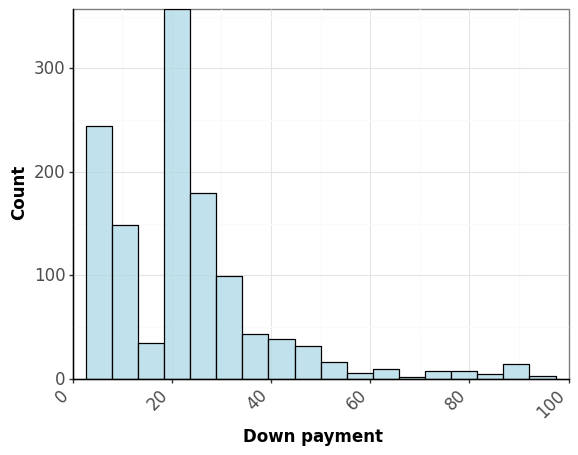

<ggplot: (8425291090566)>

In [5]:
plot_base = ggplot(df_aux,aes(x='ratio')) + geom_histogram(fill='lightblue',alpha=0.75,color='black',bins=20)

plot_clean = plot_base + theme_bw() + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=12),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_x_continuous(name = 'Down payment', limits=[0,100], expand=[0,0],breaks=[0,20,40,60,80,100])+\
scale_y_continuous(name = 'Count', expand=[0,0])

ggsave(plot_clean, ta_dir + "Fig_MortgageRatio.pdf")

plot_clean

### <font color='orange'> Mortgage values </font>

In [7]:
print('There are',len(df_TaxAssessor_selected[df_TaxAssessor_selected['Mortgage_Date'].isna()].index),'for which we do not have good information regarding mortgage')

theMedian = df_TaxAssessor_selected['Mortgage_Date'].median()
df_TaxAssessor_selected['Mortgage_Date'] = df_TaxAssessor_selected['Mortgage_Date'].apply(lambda x: theMedian if math.isnan(x) == True else x)


for i in range(len(df_TaxAssessor_selected.index)):
    # If Sale Date is missing, assume the Mortgage Date as Sale Date
    if math.isnan(df_TaxAssessor_selected.loc[i,'Sale_Date']) == True and\
      math.isnan(df_TaxAssessor_selected.loc[i,'Mortgage_Date']) == False:
        df_TaxAssessor_selected.loc[i,'Sale_Date'] = df_TaxAssessor_selected.loc[i,'Mortgage_Date']

    elif math.isnan(df_TaxAssessor_selected.loc[i,'Sale_Date']) == False and\
      math.isnan(df_TaxAssessor_selected.loc[i,'Mortgage_Date']) == True:
        df_TaxAssessor_selected.loc[i,'Mortgage_Date'] = df_TaxAssessor_selected.loc[i,'Sale_Date']


print(df_TaxAssessor_selected.shape)
df_TaxAssessor_selected.head(2)

There are 578 for which we do not have good information regarding mortgage
(4265, 10)


,FIPS,Latitude,Longitude,Sale_Code,Sale_Amount,Sale_Date,Mortgage_Amount,Mortgage_Date,Mortgage_Interest,Mortgage_End_Date
0,6081,37.474263,-122.153298,NaN,NaN,20080528.0,536000.0,20080528.0,6.75,20380601.0
1,6081,37.474234,-122.153097,F,61000.0,19800200.0,57900.0,20120928.0,NaN,NaN


### <font color='orange'> Dates as years </font>

In [8]:
df_TaxAssessor_selected['Sale_Date'] = df_TaxAssessor_selected['Sale_Date'].astype(str).str[:4].astype(int)
df_TaxAssessor_selected['Mortgage_Date'] = df_TaxAssessor_selected['Mortgage_Date'].astype(str).str[:4].astype(int)
df_TaxAssessor_selected['Mortgage_End_Date'] = df_TaxAssessor_selected['Mortgage_End_Date'].apply(lambda x: str(x)[:4] if math.isnan(x) == False else 0).astype(int)
df_TaxAssessor_selected.head(2)

,FIPS,Latitude,Longitude,Sale_Code,Sale_Amount,Sale_Date,Mortgage_Amount,Mortgage_Date,Mortgage_Interest,Mortgage_End_Date
0,6081,37.474263,-122.153298,NaN,NaN,2008,536000.0,2008,6.75,2038
1,6081,37.474234,-122.153097,F,61000.0,1980,57900.0,2012,NaN,0


/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /content/drive/MyDrive/Research/2022_FloodsEPA/TA_Data/Fig_LastTransaction.pdf
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


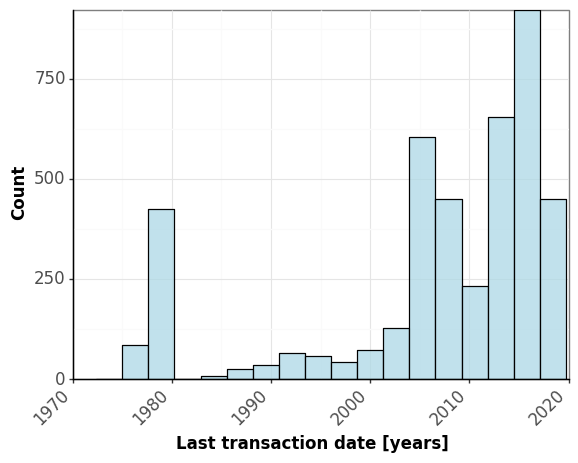

<ggplot: (8425285591749)>

In [9]:
plot_base = ggplot(df_TaxAssessor_selected,aes(x='Sale_Date')) + geom_histogram(fill='lightblue',alpha=0.75,color='black',bins=20)

plot_clean = plot_base + theme_bw() + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=12),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_x_continuous(name = 'Last transaction date [years]', limits=[1970,2020], expand=[0,0])+\
scale_y_continuous(name = 'Count', expand=[0,0])

ggsave(plot_clean, ta_dir + "Fig_LastTransaction.pdf")

plot_clean

In [10]:
len(df_TaxAssessor_selected[df_TaxAssessor_selected['Sale_Date']>=2000].index)/len(df_TaxAssessor_selected.index)

0.8192262602579132

### <font color='orange'> Mortgage Maturity </font>

In [11]:
df_TaxAssessor_selected['Mortgage_Maturity'] = df_TaxAssessor_selected['Mortgage_End_Date'] - df_TaxAssessor_selected['Mortgage_Date']
df_TaxAssessor_selected.head(2)

,FIPS,Latitude,Longitude,Sale_Code,Sale_Amount,Sale_Date,Mortgage_Amount,Mortgage_Date,Mortgage_Interest,Mortgage_End_Date,Mortgage_Maturity
0,6081,37.474263,-122.153298,NaN,NaN,2008,536000.0,2008,6.75,2038,30
1,6081,37.474234,-122.153097,F,61000.0,1980,57900.0,2012,NaN,0,-2012


The median mortgage maturity is: 30.0


array([[<Axes: title={'center': 'Mortgage_Maturity'}>]], dtype=object)

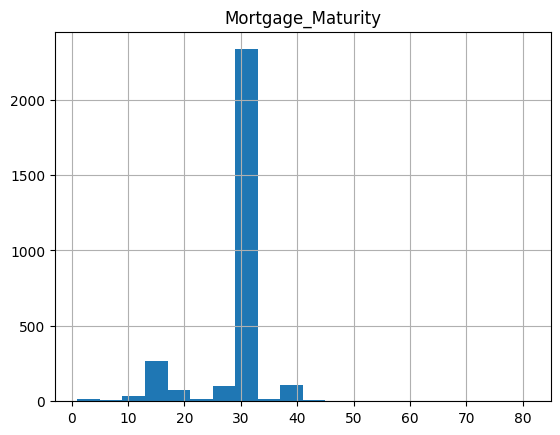

In [12]:
print('The median mortgage maturity is:',df_TaxAssessor_selected[df_TaxAssessor_selected['Mortgage_Maturity'] > 0]['Mortgage_Maturity'].median())

In [13]:
med_maturity = df_TaxAssessor_selected[df_TaxAssessor_selected['Mortgage_Maturity'] > 0]['Mortgage_Maturity'].median()
df_TaxAssessor_selected['Mortgage_Maturity'] = df_TaxAssessor_selected['Mortgage_Maturity'].apply(lambda x: med_maturity if x <= 0 else x)
df_TaxAssessor_selected.head(2)

,FIPS,Latitude,Longitude,Sale_Code,Sale_Amount,Sale_Date,Mortgage_Amount,Mortgage_Date,Mortgage_Interest,Mortgage_End_Date,Mortgage_Maturity
0,6081,37.474263,-122.153298,NaN,NaN,2008,536000.0,2008,6.75,2038,30.0
1,6081,37.474234,-122.153097,F,61000.0,1980,57900.0,2012,NaN,0,30.0


/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /content/drive/MyDrive/Research/2022_FloodsEPA/TA_Data/Fig_MortgageMaturity.pdf
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 18 rows containing non-finite values.
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 18 rows containing non-finite values.
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


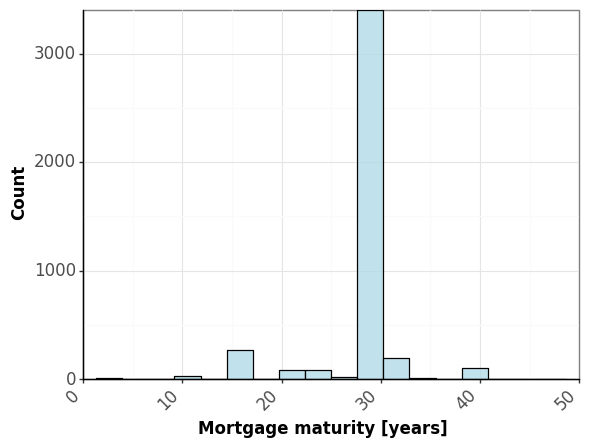

<ggplot: (8425286609311)>

In [14]:
plot_base = ggplot(df_TaxAssessor_selected,aes(x='Mortgage_Maturity')) + geom_histogram(fill='lightblue',alpha=0.75,color='black',bins=20)

plot_clean = plot_base + theme_bw() + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=12),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_x_continuous(name = 'Mortgage maturity [years]', limits=[0,50], expand=[0,0])+\
scale_y_continuous(name = 'Count', expand=[0,0])

ggsave(plot_clean, ta_dir + "Fig_MortgageMaturity.pdf")

plot_clean

### <font color='orange'> Interest rates </font>



In [32]:
print('The median interest rate is', df_TaxAssessor_selected['Mortgage_Interest'].median())
print('The mean interest rate is', df_TaxAssessor_selected['Mortgage_Interest'].mean())

The median interest rate is 4.375
The mean interest rate is 4.416499882766707


In [16]:
# Replace missing interest rates with the median value
for i in range(len(df_TaxAssessor_selected.index)):
  if math.isnan(df_TaxAssessor_selected.loc[i,'Mortgage_Interest']) == True:
      med = df_TaxAssessor_selected[df_TaxAssessor_selected['Sale_Date'] == df_TaxAssessor_selected.loc[i,'Sale_Date']]['Mortgage_Interest'].median()

      if math.isnan(med) == False:
          df_TaxAssessor_selected.loc[i,'Mortgage_Interest'] = med
      else:
          df_TaxAssessor_selected.loc[i,'Mortgage_Interest'] = df_TaxAssessor_selected['Mortgage_Interest'].median()

df_TaxAssessor_selected.head(2)

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.10/di

,FIPS,Latitude,Longitude,Sale_Code,Sale_Amount,Sale_Date,Mortgage_Amount,Mortgage_Date,Mortgage_Interest,Mortgage_End_Date,Mortgage_Maturity
0,6081,37.474263,-122.153298,NaN,NaN,2008,536000.0,2008,6.7500,2038,30.0
1,6081,37.474234,-122.153097,F,61000.0,1980,57900.0,2012,4.7575,0,30.0


/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /content/drive/MyDrive/Research/2022_FloodsEPA/TA_Data/Fig_MortgageInterestRate.pdf
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 7 rows containing non-finite values.
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 7 rows containing non-finite values.
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


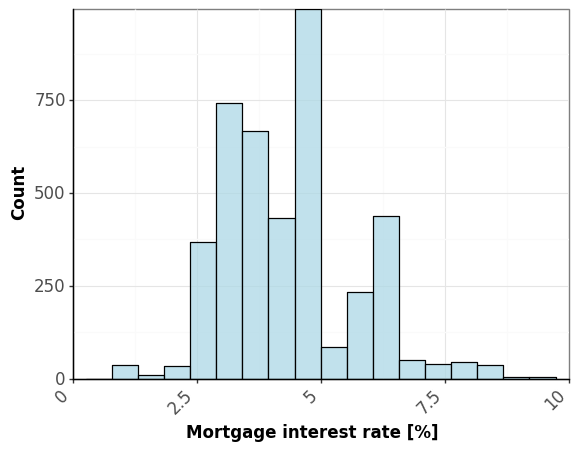

<ggplot: (8425287950306)>

In [17]:
plot_base = ggplot(df_TaxAssessor_selected,aes(x='Mortgage_Interest')) + geom_histogram(fill='lightblue',alpha=0.75,color='black',bins=20)

plot_clean = plot_base + theme_bw() + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=12),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_x_continuous(name = 'Mortgage interest rate [%]', limits=[0,10], expand=[0,0])+\
scale_y_continuous(name = 'Count', expand=[0,0])

ggsave(plot_clean, ta_dir + "Fig_MortgageInterestRate.pdf")

plot_clean

## Single-family vs multi-family

In [20]:
df_ApartmentUnits = df_TaxAssessor_raw[~df_TaxAssessor_raw['MAILING_APARTMENT_UNIT'].isna()].copy()
df_ApartmentUnits['Address'] = df_ApartmentUnits['MAILING_HOUSE_NUMBER'].astype(str) + df_ApartmentUnits['MAILING_STREET_NAME'].astype(str)
df_ApartmentUnits['Repeats'] = [1] * len(df_ApartmentUnits.index)
df_ApartmentUnits[['Address','Repeats']].groupby(by='Address',axis=0).count()

,Repeats
Address,
101.0JEFFERSON,1
1075.0SPACE PARK,1
109.0MISSION,1
111.0RENGSTORFF,1
113.0MISSION,1
...,...
766.01ST,1
794.0FLETCHER,1
7950.0MCCLELLAN,1


## <font color='orange'> Calculate owner income at time of purchase </font>

In [21]:
'''
  This cell calculates the *** minimum *** income for a homeowner who purchased a building in year X.
  We use the following equation to calculate the monthly mortgage payment
  M = P * r * (1 + r)**n / [(1+r)**n - 1]
  where:
    P = loan amount, e.g., building value.
    r = interest rate, read from a file.
    n = number of installments, we assume mortages of 30 years.

  To calculate the household income we assume a gross debt-to-income ratio (GDSR) of 30%.
  The income is calculate as:
    I = M * 12 / GDSR
'''

# Assume a gross debt-to-income ratio of 30%
theGDSR = 0.3

df_TaxAssessor_selected['OwnerIncomeAtPurchase'] = [0] * len(df_TaxAssessor_selected.index)

for i in range(len(df_TaxAssessor_selected.index)):
    # Monthly interest rate
    theMonthlyInterestRate = df_TaxAssessor_selected.loc[i,'Mortgage_Interest']/12/100 # percentage

    # Maturity in months
    theMaturity = df_TaxAssessor_selected.loc[i,'Mortgage_Maturity'] * 12

    # Monthly payment
    theMonthlyPayment = df_TaxAssessor_selected.loc[i,'Mortgage_Amount'] * theMonthlyInterestRate * (1 + theMonthlyInterestRate)**theMaturity\
                        /((1+theMonthlyInterestRate)**theMaturity - 1)

    # Minimum income to be eligible
    #df_TaxAssessor.loc[i,'OwnerIncomeAtPurchase'] = cpi.inflate(int(theMonthlyPayment * 12 / theGDSR),df_TaxAssessor.loc[i,'Mortgage_Date'],to=2021)
    df_TaxAssessor_selected.loc[i,'OwnerIncomeAtPurchase'] = int(theMonthlyPayment * 12 / theGDSR)

    # Inflate
    df_TaxAssessor_selected.loc[i,'OwnerIncomeToday'] = cpi.inflate(df_TaxAssessor_selected.loc[i,'OwnerIncomeAtPurchase'],df_TaxAssessor_selected.loc[i,'Sale_Date'],to=2021)

    # Ad-hoc fixing some low incomes
    medianIncome = df_TaxAssessor_selected[df_TaxAssessor_selected['Sale_Date']==df_TaxAssessor_selected.loc[i,'Sale_Date']]['OwnerIncomeToday'].median()
    medianMortgage = df_TaxAssessor_selected[df_TaxAssessor_selected['Sale_Date']==df_TaxAssessor_selected.loc[i,'Sale_Date']]['Mortgage_Amount'].median()
    check = 2 * df_TaxAssessor_selected.loc[i,'Mortgage_Amount'] / medianMortgage

    if check < 1:
        df_TaxAssessor_selected.loc[i,'OwnerIncomeToday'] = medianIncome

df_TaxAssessor_selected.head(10)

,FIPS,Latitude,Longitude,Sale_Code,Sale_Amount,Sale_Date,Mortgage_Amount,Mortgage_Date,Mortgage_Interest,Mortgage_End_Date,Mortgage_Maturity,OwnerIncomeAtPurchase,OwnerIncomeToday
0,6081,37.474263,-122.153298,NaN,NaN,2008,536000.0,2008,6.7500,2038,30.0,139059,175012.968839
1,6081,37.474234,-122.153097,F,61000.0,1980,57900.0,2012,4.7575,0,30.0,12091,39760.901335
2,6081,37.474180,-122.152718,NaN,NaN,2004,150000.0,2004,4.8500,2019,15.0,46980,67391.056644
3,6081,37.474154,-122.152509,P,NaN,2006,495000.0,2006,6.5250,2036,30.0,125475,168650.598958
4,6081,37.474124,-122.152309,NaN,NaN,2006,45000.0,2006,6.5250,2016,10.0,20461,98076.086111
5,6081,37.474097,-122.152113,F,55000.0,1979,51000.0,2012,4.8075,0,30.0,10712,39981.138292
6,6081,37.474115,-122.151671,NaN,NaN,2006,190000.0,2006,6.5250,2036,30.0,48162,98076.086111
7,6081,37.473957,-122.151732,NaN,NaN,2007,455000.0,2007,6.8750,2037,30.0,119561,156251.237906
8,6081,37.474008,-122.151475,NaN,NaN,2017,1.0,2017,4.4330,2075,58.0,0,0.000000
9,6081,37.473961,-122.151136,NaN,NaN,2003,232000.0,2003,4.7500,2033,30.0,48408,71288.672609


In [22]:
import plotly.graph_objects as go

df_plt = df_TaxAssessor_selected.copy()
df_plt['OwnerIncomeToday'] = df_TaxAssessor_selected['OwnerIncomeToday'].apply(lambda x: 200000 if x > 200000 else x)
df_plt['Size'] = [1] * len(df_plt.index)

fig = px.scatter_mapbox(df_plt,
                        lat = df_plt['Latitude'],
                        lon = df_plt['Longitude'],
                        color="OwnerIncomeToday",
                        center={"lat": 37.467, "lon": -122.137},
                        mapbox_style="carto-positron",
                        color_continuous_scale='Viridis',
                        opacity = 0.5,
                        #size = 'Size',
                        #hover_data = ['Units','Tenure'],
                        zoom=13,
                        height=700,
                        width=800
                      )

fig.show()

In [24]:
# Calculate home value assuming 20% downpayment
df_TaxAssessor_selected['HomeValue'] = df_TaxAssessor_selected['Mortgage_Amount'].divide(0.8)

for i in range(len(df_TaxAssessor_selected.index)):
    df_TaxAssessor_selected.loc[i,'HomeValue'] = cpi.inflate(df_TaxAssessor_selected.loc[i,'HomeValue'],df_TaxAssessor_selected.loc[i,'Sale_Date'],to=2021)

In [25]:
for i in range(len(df_TaxAssessor_selected.index)):
    if df_TaxAssessor_selected.loc[i,'OwnerIncomeToday'] < 20000:
        df_TaxAssessor_selected.loc[i,'OwnerIncomeToday'] = df_TaxAssessor_selected[df_TaxAssessor_selected['Sale_Date'] == df_TaxAssessor_selected.loc[i,'Sale_Date']]['OwnerIncomeToday'].median()

    if df_TaxAssessor_selected.loc[i,'OwnerIncomeToday'] < 200000:
        df_TaxAssessor_selected.loc[i,'HomeValue'] = df_TaxAssessor_selected[df_TaxAssessor_selected['Sale_Date'] == df_TaxAssessor_selected.loc[i,'Sale_Date']]['HomeValue'].median()

In [27]:
df_TaxAssessor_selected[['Latitude','Longitude','Mortgage_Date','Mortgage_Maturity','HomeValue','OwnerIncomeToday']].to_csv(ta_dir+'Mortgage_Income_Data.txt',index=False)

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:718: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:719: PlotnineWarning:

Filename: /content/drive/MyDrive/Research/2022_FloodsEPA/TA_Data/Fig_HouseholdIncome.pdf



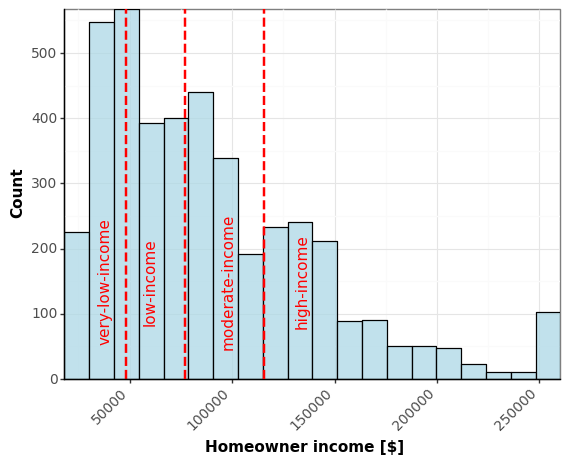

<ggplot: (8425281968071)>

In [28]:
median_income_San_Mateo = 96349

df_TaxAssessor_selected['OwnerIncomeToday'] = df_TaxAssessor_selected['OwnerIncomeToday'].apply(lambda x: 250000 if x > 250000 else x)

plot_base = ggplot(df_TaxAssessor_selected,aes(x='OwnerIncomeToday')) + geom_histogram(fill='lightblue',alpha=0.75,color='black',bins=20) +\
             geom_vline(xintercept=0.5*median_income_San_Mateo,linetype='dashed',color='red',size=1) +\
             geom_vline(xintercept=0.8*median_income_San_Mateo,linetype='dashed',color='red',size=1) +\
             geom_vline(xintercept=1.2*median_income_San_Mateo,linetype='dashed',color='red',size=1) +\
             annotate('text',label='very-low-income',x=38000,y=150,color='red',angle=90) +\
             annotate('text',label='low-income',x=60000,y=150,color='red',angle=90) +\
             annotate('text',label='moderate-income',x=98000,y=150,color='red',angle=90) +\
             annotate('text',label='high-income',x=134000,y=150,color='red',angle=90)

plot_clean = plot_base + theme_bw() + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=11,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_x_continuous(name = 'Homeowner income [$]', expand=[0,0])+\
scale_y_continuous(name = 'Count', expand=[0,0])

ggsave(plot_clean, ta_dir + "Fig_HouseholdIncome.pdf")

plot_clean

In [29]:
df_Incomes = df_TaxAssessor_selected[['FIPS','Latitude','Longitude','OwnerIncomeToday']]
df_Incomes.to_csv(ta_dir+'IncomeSamples.txt')

In [34]:
df_Incomes['Bracket'] = df_Incomes['OwnerIncomeToday'].apply(lambda x: 'Very low' if x < 0.5 * median_income_San_Mateo else ('Low' if x < 0.8 * median_income_San_Mateo else\
                                                                                 ('Moderate' if x < 1.2 * median_income_San_Mateo else 'High')))
df_Incomes

<ipython-input-34-1b97318dc9ee>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,FIPS,Latitude,Longitude,OwnerIncomeToday,Bracket
0,6081,37.474263,-122.153298,175012.968839,High
1,6081,37.474234,-122.153097,39760.901335,Very low
2,6081,37.474180,-122.152718,67391.056644,Low
3,6081,37.474154,-122.152509,168650.598958,High
4,6081,37.474124,-122.152309,98076.086111,Moderate
...,...,...,...,...,...
4260,6081,37.461130,-122.135297,119139.306431,High
4261,6081,37.461130,-122.135297,113170.706813,Moderate
4262,6081,37.461130,-122.135297,79752.467496,Moderate
4263,6081,37.461130,-122.135297,93424.312026,Moderate


In [40]:
df_Incomes.groupby(by='Bracket').count()

,FIPS,Latitude,Longitude,OwnerIncomeToday
Bracket,,,,
High,1151,1151,1151,1151
Low,1063,1063,1063,1063
Moderate,1030,1030,1030,1030
Very low,1021,1021,1021,1021


In [38]:
df_Incomes.groupby(by='Bracket').count().divide(df_Incomes.shape[0])

,FIPS,Latitude,Longitude,OwnerIncomeToday
Bracket,,,,
High,0.269871,0.269871,0.269871,0.269871
Low,0.249238,0.249238,0.249238,0.249238
Moderate,0.241501,0.241501,0.241501,0.241501
Very low,0.239390,0.239390,0.239390,0.239390


In [30]:
Ends here

SyntaxError: ignored

## Calculate current income

In [ ]:
'''
  Implemente by Rodrigo Costa, February 2022
  This cell implements the homeowner income estimation by Zhang, Costa, Zsarcnosay, and Baker (in prep)

  Here, we start from the building value and the last transaction date, say 1990.
  We use this data to estimate the **minimum** income that a household would need to qualify for the mortgage for this building.
  Next, we determine the income quintile for the household in 1990, and use an income mobility model to determine the probability that they have moved up or down.
  Next, we estimate income given that the household moved to each quintile.
  Finally, we calculate the expected income of the family in 2019 dollars.
'''
# Bring values to current year
theCurrentYear = 2021

# Get hold of model parameters and data
# Income mobility model parameters - note, these parameters were fit using Bay Area Data
df_IMM = pd.read_csv(data_dir+'IMM/RAABiT_IncomeMobilityModel.txt',header=0)

# Get the income quantiles over time - note, these parameters were fit using Bay Area Data
df_IncomeQuintiles = pd.read_csv(data_dir+'IMM/Input_IncomeQuintiles.txt',header=0)

# Declare the columns we want to calculate
#df_TaxAssessor['IncomeQuintile'] = [0] * len(df_TaxAssessor.index)
df_TaxAssessor_selected['OwnerIncomeNow'] = [0] * len(df_TaxAssessor_selected.index)

theMethod = 'MultiRealizations'
theNumberOfSamples = 100
cnames = range(theNumberOfSamples)
df_Incomes = pd.DataFrame(columns = cnames)

# Perform the calculations for each building in the database
for i in range(len(df_TaxAssessor_selected.index)):#len(df_TaxAssessor.index)

    # Get year; if before 1967 use 1967; if after 2019 use 2019 because that is where the data ends
    yr = min(max(df_TaxAssessor_selected.loc[i,'Mortgage_Date'],1967),theCurrentYear)

    # Get the quintiles for the year the building was purchased
    qts = df_IncomeQuintiles[df_IncomeQuintiles['Year'] == yr].reset_index(drop=True)

    # Set the quintile to 5 to begin with in case the homeowner income is extremely high
    my_quintile = 5

    for j in range(1,len(qts.columns),1):
        # Check in which quantile the owner would fall at the time of purchase
        if qts.iloc[0,j] > df_TaxAssessor_selected.loc[i,'OwnerIncomeAtPurchase']:
            my_quintile = j-1 # update the quintile if we identify it actually falls in another bracket
            break

    # Get the time since the building was purchased
    dt = theCurrentYear - yr

    # Select the relevant rows in the income mobility model dataframe
    my_imm = df_IMM[df_IMM['From'] == my_quintile].copy().reset_index(drop=True)

    # Calculate the probability of income mobility for each quintile
    my_imm['ProbOfMobility'] = [0] * len(my_imm.index)
    for j in range(len(my_imm.index)):
        # p = a*exp(-bt) + c*exp(-dt)
        p = my_imm.loc[j,'a'] * np.exp(-my_imm.loc[j,'b']*dt) + my_imm.loc[j,'c'] * np.exp(-my_imm.loc[j,'d']*dt)
        my_imm.loc[j,'ProbOfMobility'] = p

    # Normalize so probabilities add up to 1
    my_imm['ProbOfMobility'] = my_imm['ProbOfMobility']/my_imm['ProbOfMobility'].sum()

    # Identify how well this owner does in comparison to its peers in the same income quintile
    for j in range(1,len(qts.columns),1):
        # Check in which quantile the owner would fall at the time of purchase
        if qts.iloc[0,j] > df_TaxAssessor_selected.loc[i,'OwnerIncomeAtPurchase']:
            my_income_percentile = (df_TaxAssessor_selected.loc[i,'OwnerIncomeAtPurchase'] - qts.iloc[0,j-1])/ (qts.iloc[0,j] - qts.iloc[0,j-1])
            break

    # Now, calculate the income the owner would have if they had moved to each of the quintiles
    my_imm['Income'] = [0] * len(my_imm.index)
    for j in range(len(my_imm.index)):
        my_imm.loc[j,'Income'] = df_IncomeQuintiles.iloc[0,j+1] + (df_IncomeQuintiles.iloc[0,j+2]-df_IncomeQuintiles.iloc[0,j+1]) * my_income_percentile

    # Estimate the expected income for the homeowner
    if theMethod == 'Average':
        df_TaxAssessor_selected.loc[i,'OwnerIncomeNow'] = sum(my_imm['ProbOfMobility'] * my_imm['Income'])
    else:
      for s in range(theNumberOfSamples):
          theStates = my_imm['Income']
          theProbabilities = my_imm['ProbOfMobility']
          v = rng.choice(theStates,p=theProbabilities,size=theNumberOfSamples,replace=True)
      df_Incomes.loc[len(df_Incomes.index)] = v

    # if (df_TaxAssessor.loc[i,'OwnerIncomeNow'] == 0):
    #     print(my_quintile, 'income:',my_imm['Income'],'percentile', my_income_percentile)